In [130]:
import numpy as np
import matplotlib.pyplot as plt
#from hist_match import kernels, emulator
import math
from pyDOE import lhs
from scipy.optimize import minimize
from scipy.optimize import least_squares


plt.rcParams.update({'font.size': 14})

In [131]:
def true_model(x, y):
    return np.cos(np.sqrt(x**2 + 2*y**2)) + 1/3*x


In [132]:
def LHsampling(ndim, Nsamples, boundaries):
    
    '''
    Args:
    ndim : Number of dimensions
    Nsamples : Number of training points
    Boundaries: (n x d) array of upper and lower boundaries of parameter region
    
    Returns: (d x M) array of training points
    
    '''
    
    # generate sample points
    input_train = lhs(ndim, samples=Nsamples)
    
    # adjust sample points for parameter ranges
    for i in range(ndim):
        input_train[:,i] = input_train[:,i]*(boundaries[i,1]-boundaries[i,0]) + boundaries[i,0]

    return input_train

In [155]:
# create training set

#N_y = 5    # number of points to sample
#N_x = 5
N = 20
ndim = 2
N_test = 100

output_train = np.zeros(N)
        
# define entire parameter space
x_bound = np.array([-4, 4]).reshape(1,-1)
y_bound = np.array([-4, 4]).reshape(1,-1)

input_bounds = np.concatenate((x_bound, y_bound), axis=0)

x_test = np.linspace(input_bounds[0,0], input_bounds[0,1], N_test)
y_test = np.linspace(input_bounds[1,0], input_bounds[1,1], N_test)

input_train = LHsampling(2, N, input_bounds)


for i in range(N):
    output_train[i] = true_model(input_train[i,0], input_train[i,1])



# for testing: true datapoints
true_x = 0.1
true_y = 3.8
var_exp = 0.05        # observational error
z = true_model(true_x, true_y) + np.random.normal(0,var_exp) # observed datapoint

# add noise to observations
output_train += np.random.normal(0,var_exp)

print(z)

0.7499325014054877


In [156]:
# prepare data by finding all combinations of inputs

#train_list = [x_train, y_train]
#input_train = np.array(np.meshgrid(*train_list)).T.reshape(-1, 2)

test_list = [x_test, y_test]
input_test = np.array(np.meshgrid(*test_list)).T.reshape(-1, 2)

#output_train = z_train.flatten()
# x value changes every N_y values

# does this match kernel array? i think so.

# all training points (for plotting)
training_data = np.concatenate((input_train, output_train.reshape(-1, 1)), axis=1)

In [157]:
def prepare_data(*args, n):
    
    # args = arrays of parameters
    # n = number of input dimensions
    # returns all combinations of input parameters
    
    return np.array(np.meshgrid(*args)).T.reshape(-1,n)

Text(0.5, 0, 'z')

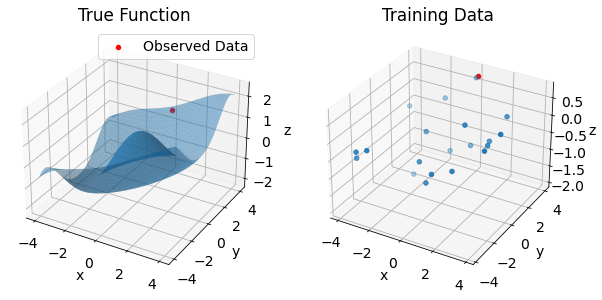

In [158]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')


X, Y = np.meshgrid(x_test, y_test)
Z = true_model(X,Y)

ax1.plot_surface(X, Y, Z, alpha=0.5)

ax1.scatter(true_x, true_y, z, color='red', label='Observed Data')
#ax.axhline(z-(3*sigma_e), linestyle='dashed', color='black', label='$\pm 3 \sigma_{e}$')
#ax.axhline(z+(3*sigma_e), linestyle='dashed', color='black')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('True Function')
ax1.legend(loc='best')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(training_data[:,0], training_data[:,1], training_data[:,2])
ax2.set_title('Training Data')
ax2.scatter(true_x, true_y, z, color='red', label='Observed Data')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')


In [159]:
# create squared-exponential kernel
d = 1              # no. of dimensions
sigma = 0.1        # sqrt variance of covariance function
theta = 1.1       # length scale
beta = 0           # prior expectation
sigma_n = 0.1      # noise variance

def kernel(x1, x2, sigma, theta):
    # (norm of x1 - x2)^2 = norm x1 ^2 + norm x2 ^2 - 2 x1.x2   (ignore sqs as sqrt below)
    # norm of x1 = sqrt(x1_1 ^2 + x1_2^2 + ...)  (sum each column, equivalent to each input vector)
    
    # x1 is m x d array
    # x2 is n x d array
    # (m*n) combinations so want (m x n) covariance matrix eventually
    # norm(x1)(column vector) - norm(x2)(row vector) gives (m x n) array corresponding to each x1 and x2 combination
    # x1 dot x2.T gives equivalent (m x n) matrix of combinations
    
    
    if x1.ndim == 1:
        x1 = x1.reshape(-1, 1)
    if x2.ndim == 1:
        x2 = x2.reshape(-1, 1)
        
    
    norm_sq = np.sum(x1**2, axis=1).reshape(-1, 1) + np.sum(x2**2, axis=1)  - 2 * np.dot(x1, x2.T)
    K = sigma**2 * np.exp(- norm_sq / ((theta**2)))
    return K

In [160]:
# log marginal likelihood function (eqn. 5.8 in Rasmussen)
def log_marginal_likelihood(hyperparameters, input_train, output_train, n, noise=False):
    
    '''
    n : number of training points
    hyperparameters: (theta, sigma, sigma_n)
        theta : length scale
        sigma : # sqrt variance of covariance function (SE func)
        sigma_n : sqrt variance of uncorrelated noise
    
    '''
    
    x = input_train
    z = output_train
    theta = hyperparameters[0]
    sigma = hyperparameters[1]
    sigma_n = hyperparameters[2]
    if noise == True:
        K = kernel(x, x, sigma, theta) + (sigma_n**2)*np.eye(n)
    else:
        K = kernel(x, x, sigma, theta)
        
    K_inv = np.linalg.inv(K)
    return 0.5 * ( (z.T).dot((K_inv.dot(z))) + np.log(np.linalg.det(K)) + n*np.log(2*np.pi) )
    

In [161]:
# log marginal likelihood function (eqn. 5.8 in Rasmussen)
def neg_ML(hyperparameters, sigma, input_train, output_train, n):
    
    '''
    n : number of training points
    hyperparameters: (theta, sigma)
    theta : length scale
    sigma : # sqrt variance of covariance function (SE func)
    
    '''
    
    x = input_train
    z = output_train
    theta = hyperparameters
    #sigma = hyperparameters[1]
    K = kernel(x, x, sigma, theta)
    K_inv = np.linalg.inv(K)
    return 0.5 * ( (z.T).dot((K_inv.dot(z))) + np.log(np.linalg.det(K)) + n*np.log(2*np.pi) )
    

In [162]:
thetas = np.linspace(0.0001,3,20)
sigmas = np.linspace(0.01,1.5,20)
sigma_ns = np.linspace(0.01,3,20)

likelihoods = np.zeros((len(thetas),3))

likeli_test = np.zeros((len(thetas),len(sigmas)))
for i in range(len(thetas)):
    likelihoods[i,0] = log_marginal_likelihood([thetas[i], sigma, sigma_n], input_train, output_train, N, noise=True)
    likelihoods[i,1] = log_marginal_likelihood([theta, sigmas[i], sigma_n], input_train, output_train, N, noise=True)
    likelihoods[i,2] = log_marginal_likelihood([theta, sigma, sigma_ns[i]], input_train, output_train, N, noise=True)

for i in range(len(thetas)):
    for j in range(len(sigmas)):
        likeli_test[i,j] = neg_ML([thetas[i], sigmas[j], sigma_n], input_train, output_train, N)
    
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
ax1.plot(thetas, likelihoods[:,0])
ax1.set_xlabel(r'length scale, $\theta$')
ax1.set_ylabel('log marginal likelihood')
ax2.plot(sigmas, -likelihoods[:,1])
ax2.set_xlabel(r'sqrt variance of covariance function, $\sigma_u$')
ax2.set_ylabel('log marginal likelihood')
ax2.set_ylim(-100,0)
ax3.plot(sigma_ns, -likelihoods[:,2])
ax3.set_xlabel(r'sqrt variance of noise, $\sigma_n$')
ax3.set_ylabel('log marginal likelihood')

TypeError: neg_ML() missing 1 required positional argument: 'n'

In [163]:
result = least_squares(neg_ML, x0=0.1, args=(sigma, input_train, output_train, len(input_train)), bounds=(0.1,3))
print(result)

#plt.contourf(thetas,sigmas,likeli_test)
#plt.scatter(result.x[0], result.x[1])
#plt.colorbar()

 active_mask: array([-1])
        cost: 100242.67863801427
         fun: array([447.75591261])
        grad: array([0.])
         jac: array([[0.]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 1
        njev: 1
  optimality: 0.0
      status: 1
     success: True
           x: array([0.1])


In [164]:
def optimise_hyperparameters(sigma, input_train, output_train, N):
    #result = minimize(neg_ML, x0 = [0.1,0.1], args=(input_train, output_train, len(input_train)), method='SLSQP', bounds=((0.01,10),(0.01,10)))
    #result = least_squares(neg_ML, [0.1,0.1], args=(input_train, output_train, len(input_train)), bounds=([0.1,0.1],[3,3]))
    #return result.x[0], result.x[1]

    result = least_squares(neg_ML, 0.1, args=(sigma, input_train, output_train, len(input_train)), bounds=(0.1,3))
    return result.x

In [165]:
# create posterior (using eqn 2.19 in Rasmussen)

def emulator(input_train, input_test, output_train, sigma, theta, sigma_n, beta, noise=False):
    
    # sigma_n : Gaussian noise on observations
    
    if noise == True:
        K_XX = kernel(input_train, input_train, sigma, theta) + (sigma_n**2)*np.eye(len(input_train))
    else:
        K_XX = kernel(input_train, input_train, sigma, theta)
    K_XsX = kernel(input_test, input_train, sigma, theta                                                                                                                                        )
    K_XXs = kernel(input_train, input_test, sigma, theta)
    K_XsXs = kernel(input_test, input_test, sigma, theta)
    K_XX_inv = np.linalg.inv(K_XX)
    
    mu = beta + K_XsX.dot(K_XX_inv).dot(output_train - beta)
    cov = K_XsXs - K_XsX.dot(K_XX_inv).dot(K_XXs)
    
    # put abs for now but SHOULD NOT BE NEGATIVE!!!!
    sd = np.sqrt(np.abs(np.diag(cov)))
    
    return mu, cov, sd

In [166]:
mu, cov, sd = emulator(input_train, input_test, output_train, sigma, theta, sigma_n, beta, noise=False)
sd2 = sd.reshape(N_test,N_test)

KeyboardInterrupt: 

In [ ]:
mu_matrix = mu.reshape(N_test,N_test)
X2, Y2 = np.meshgrid(x_test, y_test)

fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot_surface(X, Y, Z, alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('True Function')
ax1.scatter(true_x, true_y, z, color='red', label='Observed Data')

#ax2.plot_surface(X2, Y2, mu_matrix, alpha=0.5)
ax2.scatter(input_test[:,0], input_test[:,1], mu_matrix.flatten(), s=1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Emulator Model')
ax1.scatter(true_x, true_y, z, color='red', label='Observed Data')

ax3.plot(y_test, mu_matrix[:,0])
ax3.set_xlabel('y')
ax3.set_ylabel('z')
ax3.set_title('Emulator Model (x=-5)')

ax3.fill_between(y_test, mu_matrix[:,0] + 3*sd2[:,0], mu_matrix[:,0] - 3*sd2[:,0], alpha=0.2, color='orange')



In [ ]:
# define implausibility measure

def implausibility(E, z, var, var_md, var_obs):
    
    # E - emulator expectation
    # z - observational data
    # var_em - emulator uncertainty
    # var_md - model discrepency error
    # var_obs - observational error
    
    return np.sqrt( ( E - z )**2  /  ( var + var_md + var_obs ) )

In [ ]:
def convergence_check(var_em, var_md, var_obs, N_nonimplausible):
    
    # var_em - emulator uncertainty
    # var_md - model discrepency error
    # var_obs - observational error
    
    if var_md != 0:
        if np.mean(var_em) < var_md:
            print('Emulator uncertainty less than model discrepency')
            return True
    elif np.mean(var_em) < var_obs:
            print('Emulator uncertainty less than observational error')
            print(np.mean(var_em))
            print(var_obs)
            return True
    elif N_nonimplausible == 0:
            print('Nonimplausible space is empty')
            return True
    else:
        return False

In [ ]:
def history_match(parameter_bounds, sigma_n, sigma, var_exp, beta, ndim, N_training_pts, N_test_pts, waves=1, noise=False):
    
    # generate points of parameter volume
    x_test = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], N_test_pts)
    y_test = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], N_test_pts)
    
    xmin_0 = parameter_bounds[0,0]
    xmax_0 = parameter_bounds[0,1]
    ymin_0 = parameter_bounds[1,0]
    ymax_0 = parameter_bounds[1,1]
    
    # generate initial training points
    input_train = LHsampling(ndim, N_training_pts, parameter_bounds)
    output_train = np.zeros(N_training_pts)
    for i in range(N_training_pts):
        output_train[i] = true_model(input_train[i,0], input_train[i,1])
    
    if noise == True:
    # add noise to observations
        output_train += 0.1 * np.random.randn(N)
    
    # prepare data by finding all combinations of inputs
    input_test = prepare_data(x_test, y_test, n=ndim)
    N_test_pts = len(input_test)
    
    # plot settings
    fig, axes = plt.subplots(waves, 4, figsize=(20, 6*waves))
    ax_list = fig.axes
    
    #testarray = np.zeros(N_test_pts)
    
    for k in range(waves):
        
        print('Current wave: ' + str(k+1))
        
        theta = optimise_hyperparameters(sigma, input_train, output_train, N_training_pts)
        sigma_u = sigma
        print(theta, sigma_u)
        
        
        # fit emulator using training points
        mu, cov, sd = emulator(input_train, input_test, output_train, sigma_u, theta, sigma_n, beta, noise)
        #if k == 0:
            #sd0 = sd.reshape((int(np.sqrt(N_test_pts)), int(np.sqrt(N_test_pts))))
            #mu0 = mu.reshape((int(np.sqrt(N_test_pts)), int(np.sqrt(N_test_pts))))
        
        # evaluate implausibility over parameter space
            #for i in range(int(np.sqrt(N_test_pts))):
                #for j in range(int(np.sqrt(N_test_pts))):   
                    #testarray[i,j] = implausibility(mu0[i,j], z, sd0[i,j], 0, sigma_e**2)
        
        implaus = np.zeros(N_test_pts)
        for i in range(N_test_pts):
            implaus[i] = implausibility(mu[i], z, np.diag(cov)[i], 0, var_exp)
        
        # plot implausibilities
        ax1 = ax_list[4*k]
        ax2 = ax_list[4*k + 1]
        ax3 = ax_list[4*k + 2]
        ax4 = ax_list[4*k + 3]
        im =  ax1.tricontourf(input_test[:,0],input_test[:,1],implaus, levels=30, cmap='viridis_r')
        
        #X, Y = np.meshgrid(x_test, y_test)
        
        #im = ax1.contourf(X.T, Y.T, implaus, 30, cmap='viridis_r')
        ax1.set_facecolor((68/255,1/255,84/255))
        ax1.set_xlim([xmin_0, xmax_0])
        ax1.set_ylim([ymin_0, ymax_0])
        cbar = fig.colorbar(im, ax=ax1)
        cbar.set_label('Implausibility')
        im.set_clim(0,10)
        ax1.set_ylabel('y')
        ax1.set_xlabel('x')
        ax1.set_title('Wave ' + str(k+1) + ' Implausibility')
        ax1.scatter(true_x, true_y, color='red', marker='x', label='Observed Data')
        
        # identify implausible region
        data = np.concatenate((input_test, implaus.reshape(-1,1)), axis=1)
        nonimplausible = np.delete(data, np.where(data[:,2] > 3), axis=0)
        
        if k == 0:
            testarray = data
        
        
        # find nonimplausible boundaries
        xmin = nonimplausible[:,0].min()
        xmax = nonimplausible[:,0].max()
        ymin = nonimplausible[:,1].min()
        ymax = nonimplausible[:,1].max()
        
        # redefine nonimplausible space
        
        input_test = nonimplausible[:,0:2]
        N_test_pts = len(input_test)
        print(N_test_pts)
        
        #_test = np.linspace(xmin, xmax, N_test_pts)
        #_test = np.linspace(ymin, ymax, N_test_pts)
        #input_test = prepare_data(x_test, y_test, n=ndim)
        
        # generate new training points in nonimplausible region
        
        boundaries = np.zeros((ndim, 2))
        for i in range(ndim):
            boundaries[i,0] = nonimplausible[:,i].min()
            boundaries[i,1] = nonimplausible[:,i].max()
            
        input_train = LHsampling(ndim, N_training_pts, boundaries)
        
        # evaluate model over new training data
        output_train = np.zeros(N_training_pts)
        for i in range(N_training_pts):
            output_train[i] = true_model(input_train[i,0], input_train[i,1])
        
        # plot nonimplausible datapoints
        ax2.scatter(nonimplausible[:,0], nonimplausible[:,1], s=2)
        ax2.scatter(true_x, true_y, color='red', marker='x', label='Observed Data')
        ax2.set_title('Remaining Non-Implausible Datapoints')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_xlim([-2,2])
        ax2.set_ylim([-2,2])
        ax2.scatter(input_train[:,0], input_train[:,1], marker='x', color='black', label='Training Data')
        ax2.axhline(ymin, linestyle = '--', color='pink')
        ax2.axhline(ymax, linestyle = '--', color='pink')
        ax2.axvline(xmin, linestyle = '--', color='pink')
        ax2.axvline(xmax, linestyle = '--', color='pink')
        ax2.legend(loc='lower left')
        
        for j in range(10):
            for i in range(10):
                box = testarray[(0+100*i)+(10*j):(10+100*i)+(10*j)]
            
        n_grid = 20
        hist, xedges, yedges = np.histogram2d(nonimplausible[:,1], nonimplausible[:,0], bins=n_grid, range=[[-2, 2], [-2, 2]])


        
        im2 = ax3.contourf(np.linspace(-2,2,n_grid),np.linspace(-2,2,n_grid),hist/((100/20)**2),cmap='pink')
        cbar = fig.colorbar(im2, ax=ax3)
        im2.set_clim(0,1)
        ax3.set_title('Optical Depth')
        ax3.set_ylabel('y')
        ax3.set_xlabel('x')
        
        #1D implausibility plot for lowest y value
        imp_y0 = data[np.where(data[:,1] == np.min(data[:,1]))]
        #ax4.plot(imp_y0[:,0],imp_y0[:,2])
        
        #for i in range(len(imp_y0[:,0])):
            #if imp_y0[i,2] > 3.5:
                #ax4.scatter(imp_y0[i,0], 1, color='red', marker='s')
            #elif imp_y0[i,2] < 3:
                #ax4.scatter(imp_y0[i,0], 1, color='green', marker='s')
            #else:
                #ax4.scatter(imp_y0[i,0], 1, color='orange', marker='s')
                 
                 
        # check to see if finishing conditions are met
        #if convergence_check(np.diag(cov), 0, var_e, N_test_pts) == True:
            #print('Waves terminated')
            #return None
            
        x_vals = np.unique(data[:,0])
        counts = np.zeros(len(x_vals))
        for i in range(len(x_vals)):
            j = np.where(data[:,0] == x_vals[i])
            imp_vals = data[j][:,2]
            counts[i] = (imp_vals < 3).sum()
        
        ax4.plot(x_vals, counts)
        ax4.set_xlim((-2,2))
        
        

In [ ]:
history_match(input_bounds, sigma_n, sigma, var_exp, beta, 2, N, N_test, 3, noise=False)